In [1]:
# Cell 1: Environment setup, imports & agent initialization

import os
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt

# 1) Switch to project root (assuming this notebook lives in /notebooks/)
os.chdir(os.path.abspath(".."))
sys.path.insert(0, os.getcwd())

print("Working directory:", os.getcwd())

# 2) Enable inline plotting
%matplotlib inline

# 3) Import and instantiate your master agent
from agents.master_agent import MasterAgent
agent = MasterAgent()


Working directory: /Users/alexsalman/Projects/mimiciv_project


/opt/homebrew/Caskroom/miniforge/base/envs/mimiciv_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🧠 Initializing Master Agent...
🔍 Initializing Retrieval Agent...
✅ Retrieval Agent ready.
✅ Master Agent ready.


In [2]:
# Cell 2: Summarization latency test

print("🔍 Retrieving one sample record for summarization test...")
sample = agent.retrieval_agent.retrieve(
    "elderly patient with chest pain and cough", k=1
)[0]
# handle either key
text = sample.get("summary", sample.get("text_summary"))
if not text:
    raise RuntimeError(f"No summary field found in record keys: {list(sample.keys())}")

print(f"Sample text length: {len(text)} characters")

t0 = time.time()
summary = agent.summarizer.summarize(text)
elapsed = time.time() - t0

print("\n📝 Summary (first 200 chars):")
print(summary.replace("\n", " ")[:200] + " …")
print(f"\n⏱ Summarization took {elapsed:.3f} seconds")


🔍 Retrieving one sample record for summarization test...
🔎 Retrieving top 1 results for query: elderly patient with chest pain and cough
Sample text length: 181 characters

📝 Summary (first 200 chars):
75-year-old male presented as an emergency to the ICU at 08:55 on September 28, 2019 (Admission Time). Diagnosis was septic shock related to complicated urinary tract infection (Diagnoses: 9975 under  …

⏱ Summarization took 3.145 seconds


In [3]:
# Cell 3: Diagnosis latency test

print("🩺 Timing diagnosis on the generated summary...")

t0 = time.time()
diagnoses = agent.diagnoser.diagnose(summary)
elapsed = time.time() - t0

print("\n💡 Diagnoses (first 200 chars):")
print(diagnoses.replace("\n", " ")[:200] + " …")
print(f"\n⏱ Diagnosis took {elapsed:.3f} seconds")


🩺 Timing diagnosis on the generated summary...

💡 Diagnoses (first 200 chars):
* **Complicated urinary tract infection:** The patient's symptoms and diagnosis of septic shock suggest a severe infection involving the urinary tract.   * **Septic shock:** The presence of infection  …

⏱ Diagnosis took 1.537 seconds


In [4]:
# Cell 4: End-to-end pipeline timing for multiple queries

queries = [
    "elderly patient with chest pain and cough",
    "ICU patient with sepsis and hypotension",
    "diabetic patient with foot ulcer and infection",
]

records = []
for q in queries:
    print(f"▶️ Running full pipeline for query: {q}")
    t0 = time.time()
    out = agent.handle_query(q, top_k=3)  # ensure your MasterAgent accepts top_k
    total = time.time() - t0

    records.append({
        "query":         q,
        "total_time_s":  round(total, 2),
        "feedback_score": out["feedback_score"],
        "summary":        out["summary"][:100] + "…",
        "diagnoses":      out["diagnoses"][:100] + "…",
    })

df_full = pd.DataFrame(records)
df_full


▶️ Running full pipeline for query: elderly patient with chest pain and cough

🔍 Retrieving top 3 similar cases for query: elderly patient with chest pain and cough
🔎 Retrieving top 3 results for query: elderly patient with chest pain and cough

📝 Summarizing patient data...

🩺 Suggesting possible diagnoses...
▶️ Running full pipeline for query: ICU patient with sepsis and hypotension

🔍 Retrieving top 3 similar cases for query: ICU patient with sepsis and hypotension
🔎 Retrieving top 3 results for query: ICU patient with sepsis and hypotension

📝 Summarizing patient data...

🩺 Suggesting possible diagnoses...
▶️ Running full pipeline for query: diabetic patient with foot ulcer and infection

🔍 Retrieving top 3 similar cases for query: diabetic patient with foot ulcer and infection
🔎 Retrieving top 3 results for query: diabetic patient with foot ulcer and infection

📝 Summarizing patient data...

🩺 Suggesting possible diagnoses...


,query,total_time_s,feedback_score,summary,diagnoses
0,elderly patient with chest pain and cough,6.48,1.0,75-year-old male presented EMERGENCY at ICU on...,## Most likely diagnoses:\n\n**1. Sepsis:**\n\...
1,ICU patient with sepsis and hypotension,7.52,1.0,"Patient ID: 19441121, Age: 52, Gender: Female\...",## Most likely diagnoses:\n\n**1. Acute Respir...
2,diabetic patient with foot ulcer and infection,6.98,1.0,"patient ID: 14403200\n age: 78, gender: F\n ...",## Most likely diagnoses:\n\n**1) Bone marrow ...


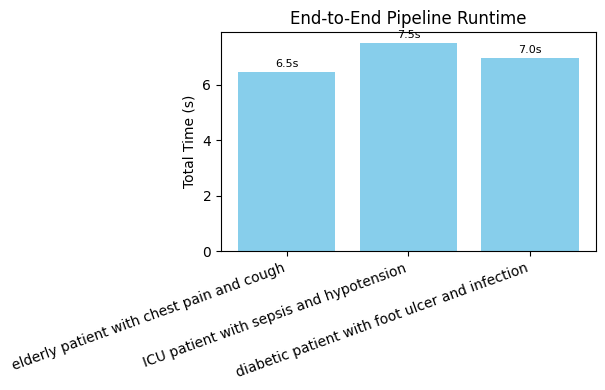

In [5]:
# Cell 5: Plot total end-to-end runtime per query

plt.figure(figsize=(6,4))
bars = plt.bar(df_full["query"], df_full["total_time_s"], color="skyblue")
plt.ylabel("Total Time (s)")
plt.title("End-to-End Pipeline Runtime")
plt.xticks(rotation=20, ha="right")

# annotate bar values
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 0.1,
             f"{y:.1f}s", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


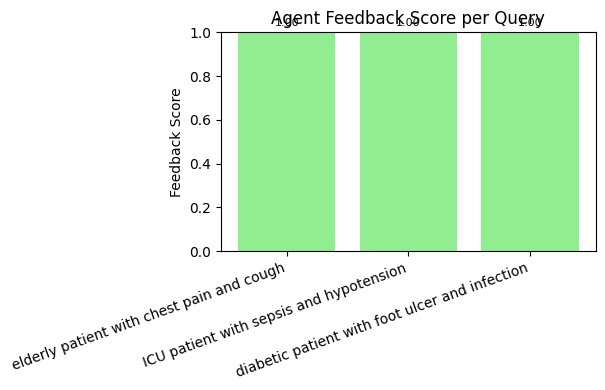

In [6]:
# Cell 6: Plot feedback scores for each query

plt.figure(figsize=(6,4))
bars = plt.bar(df_full["query"], df_full["feedback_score"], color="lightgreen")
plt.ylim(0, 1)
plt.ylabel("Feedback Score")
plt.title("Agent Feedback Score per Query")
plt.xticks(rotation=20, ha="right")

# annotate bar values
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 0.02,
             f"{y:.2f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()
